This is a cross-validation (back-testing) of the medians on the new 794-day data set. I used ten 62-days segments and compared several medians in the range of 7 to 140 days immediately before each 62-days period (with data grouped by weekends/weekdays). The conclusion is that the medians are quite robust with the best being around 4 weeks leading to SMAPE of 44.3 with a standard deviation of 3.0 (or a range between 39 and 49).   I do this to have a benchmark for any ML algorithm.

 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime, gc

print('loading files and re-shaping...')
train = pd.read_csv('../input/train_2.csv') 
train.fillna(0, inplace=True)
test = pd.melt(train[list(train.columns[-62:])+['Page']], id_vars='Page', var_name='D62', value_name='V62')
test['D62']= test['D62'].astype('datetime64[ns]')
test['Date']=test['D62']+ datetime.timedelta(days=74) # to match the test set starting on 13 Sep
test['D62']= test['D62'].dt.dayofweek  >= 5      # take in account weekly seasonality
    
Windows = [7,28,49,63,140]    # windows to take the median over (just a few due to time limit)
n=11   # chose the number of CV sets (up to 12 depending on max Windows size)
cvlist=list(range(62,n*62,62))

for i in range(2,n):
    tmp = pd.melt(train[list(train.columns[-62*i:-62*(i-1)])+['Page']], 
                id_vars='Page', var_name='D'+str(i*62), value_name='V'+str(i*62) )
    tmp.drop(['Page'],axis=1,inplace=True)
    tmp['D'+str(i*62)]= tmp['D'+str(i*62)].astype('datetime64[ns]').dt.dayofweek  >= 5
    test = pd.concat([test, tmp], axis=1, join_axes=[test.index])
del tmp                      
gc.collect()
def smape(t,p):  return 200.* ((t-p).abs()/(p.abs()+t.abs()).replace({0:1})).mean()
print(test.shape)
test.head(2)


loading files and re-shaping...
(8993906, 22)


,Page,D62,V62,Date,D124,V124,D186,V186,D248,V248,...,D372,V372,D434,V434,D496,V496,D558,V558,D620,V620
0,2NE1_zh.wikipedia.org_all-access_spider,True,23.0,2017-09-13,True,36.0,False,39.0,False,20.0,...,False,14.0,False,22.0,True,31.0,True,11.0,False,12.0
1,2PM_zh.wikipedia.org_all-access_spider,True,15.0,2017-09-13,True,12.0,False,24.0,False,30.0,...,False,23.0,False,24.0,True,17.0,True,20.0,False,9.0


In [2]:
# collect smape values with Windows in rows and CV sets in columns
mw=[]
for i in Windows: mw=mw+['MW'+str(i)]
colmw=[]
for cv in cvlist: colmw=colmw+['MW_'+str(cv)]
smapeMW=pd.DataFrame(0,index=mw, columns=colmw)

for cv in cvlist:
    Day='D'+str(cv)
    for i in Windows:
        print(cv,i, end=' ')
        tmp = pd.melt(train[list(train.columns[-i-cv:-cv])+['Page']], 
                  id_vars='Page', var_name=Day, value_name='MW'+str(i))
        tmp[Day]= tmp[Day].astype('datetime64[ns]').dt.dayofweek  >= 5
        tmp1 = tmp.groupby(['Page',Day]).median().reset_index()
        test = test.merge(tmp1, how='left')
    print(test.shape)
    del tmp,tmp1
    gc.collect()
    
    for i in range(0,len(mw)) :    
        smapeMW.loc[mw[i],'MW_'+str(cv)] = smape(test['V'+str(cv)],test[mw[i]])
    test.drop(mw,axis=1,inplace=True)

62 7 62 28 62 49 62 63 62 140 (8993906, 27)
124 7 124 28 124 49 124 63 124 140 (8993906, 27)
186 7 186 28 186 49 186 63 186 140 (8993906, 27)
248 7 248 28 248 49 248 63 248 140 (8993906, 27)
310 7 310 28 310 49 310 63 310 140 (8993906, 27)
372 7 372 28 372 49 372 63 372 140 (8993906, 27)
434 7 434 28 434 49 434 63 434 140 (8993906, 27)
496 7 496 28 496 49 496 63 496 140 (8993906, 27)
558 7 558 28 558 49 558 63 558 140 (8993906, 27)
620 7 620 28 620 49 620 63 620 140 (8993906, 27)


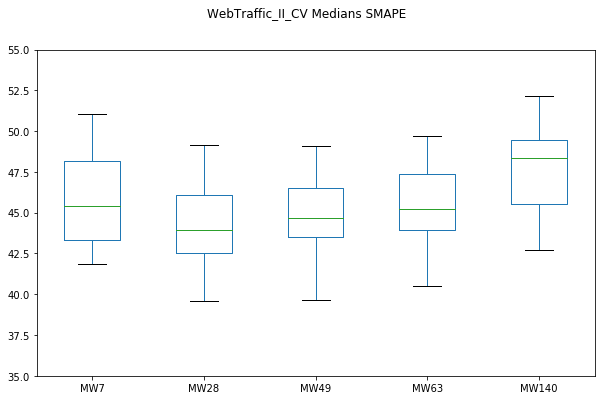

In [3]:
plt.clf()
fig = plt.figure()
smapeMW.loc[:,colmw].T.plot(kind='box',ylim=(35,55), figsize=(10,6))
plt.suptitle('WebTraffic_II_CV Medians SMAPE', size=12)
plt.savefig('WebTraffic_II_CV Medians.jpg')
plt.show()

In [4]:
smapeMW['std']=smapeMW.loc[:,colmw].std(axis=1)
smapeMW['mean']=smapeMW.loc[:,colmw].mean(axis=1)
smapeMW

,MW_62,MW_124,MW_186,MW_248,MW_310,MW_372,MW_434,MW_496,MW_558,MW_620,std,mean
MW7,42.535965,41.826910,43.095144,51.033637,46.406463,49.824843,48.797923,44.720947,43.965947,46.121388,3.185415,45.832917
MW28,41.050365,39.559930,42.290276,46.373719,45.240513,49.170640,48.150417,43.697177,43.196405,44.220044,3.025605,44.294949
MW49,41.443355,39.656274,43.346373,46.242342,46.589076,48.800483,49.081523,44.729767,44.125403,44.596219,2.979908,44.861082
MW63,41.818667,40.509563,43.708610,46.678119,47.584076,48.901294,49.678471,45.493351,44.624514,44.987068,2.931663,45.398373
MW140,44.467011,42.694172,45.142277,48.942034,51.165900,49.636853,52.185521,48.285042,46.715476,48.447011,3.005589,47.768130


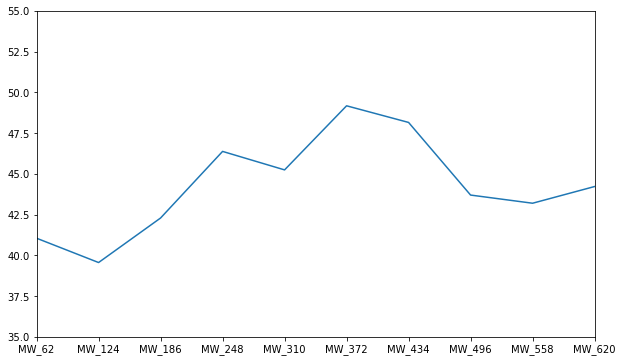

In [5]:
plt.clf()
smapeMW.loc['MW28',colmw].plot(ylim=(35,55), figsize=(10,6))
plt.show()

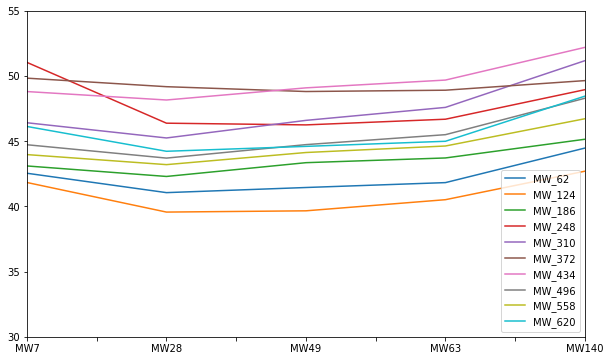

In [6]:
plt.clf()
smapeMW.loc[:,colmw].plot(ylim=(30,55), figsize=(10,6))
plt.show()

The old LB corresponded to MW_248 (approximately) with score about 46.